In [21]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [149]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pdb
import altair as alt
from plotnine import *

<IPython.core.display.Javascript object>

In [23]:
policies = pd.read_csv("../cantwait_data.csv")
policies.head()

,policy,existing adherents,n,reduction
0,require deescalation,34,91,0.15
1,use force continuum or matrix,77,91,0.19
2,restrict holds,21,91,0.22
3,require warning,56,91,0.05
4,prohibit shooting at moving vehicles,19,91,0.08


<IPython.core.display.Javascript object>

In [26]:
name_map = {'St. Paul':'St Paul',
            'Saint Paul':'St Paul',
            'St. Petersburg':'St Petersburg',
            'Saint Petersburg':'St Petersburg',
            'St. Louis':'St Louis',
            'Saint Louis':'St Louis'}

<IPython.core.display.Javascript object>

In [28]:
city_state_only = {'Arlington':'TX',
                    'Aurora':'CO',
                'Austin' :'TX',
                'Aurora' :'CO',
                'Boston' :'MA',
                'Buffalo' :'NY',
                'Cleveland' :'OH',
                'Columbus' :'OH',
                'Dallas' :'TX',
                'Durham' :'NC',
                'Glendale' :'AZ',
                'Greensboro' :'NC',
                'Henderson' :'NV',
                'Houston' :'TX',
                'Jacksonville' :'FL',
                'Kansas City' :'MO',
                'Las Vegas' :'NV',
                'Lexington' :'KY',
                'Lincoln' :'NE',
                'Louisville' :'KY',
                'Madison' :'WI',
                'Mesa' :'AZ',
                'Miami' :'FL',
                'Nashville' :'TN',
                'Newark' :'NJ',
                'Norfolk' :'VA',
                'Orlando' :'FL',
                'Phoenix' :'AZ',
                'Portland' :'OR',
                'Reno' :'NV',
                'Rochester' :'NY',
                'Stockton' :'CA'
                  }

<IPython.core.display.Javascript object>

In [58]:
deaths_raw = pd.read_csv("../MPV_data.csv", dtype={'city':'str', 'state':'str'}, parse_dates  = ['date'])

cityname_mask = deaths_raw.city.isin(name_map.keys())
deaths_raw.loc[cityname_mask, 'city'] = deaths_raw.loc[cityname_mask, 'city'].map(name_map)

for city, state in city_state_only.items():
    deaths_raw.loc[(deaths_raw.city == city) & (deaths_raw.state == state), 'city'] = "NA"

<IPython.core.display.Javascript object>

In [59]:
deaths_DOJ = pd.read_csv('../custody_deaths.csv')
deaths_DOJ.head()

,state,num_deaths,pct_confirmed,pct_media,pct_survey,pop2010
0,Alabama,7.0,85.7,100.0,0.0,4779736
1,Alaska,0.0,NaN,NaN,NaN,710231
2,Arkansas,1.0,100.0,100.0,0.0,2915918
3,Arizona,10.0,100.0,90.0,10.0,6392017
4,California,65.0,87.7,92.3,7.7,37253956


<IPython.core.display.Javascript object>

In [133]:
cities_raw = pd.read_csv('../policies_by_city.csv')
cities_raw = cities_raw[cities_raw.state !='DC']
cities_raw

,city,state,pop2010,black_pop2010,white_pop2010,require deescalation,use force continuum or matrix,restrict holds,require warning,prohibit shooting at moving vehicles,require exhaustion of alternatives,require officer intervention,require reporting,deaths2016
0,Albuquerque,New Mexico,545852,17933,380552,1,1,0,1,1,0,1,0,5
1,Anaheim,California,336265,9347,177237,0,1,0,1,0,0,1,0,6
2,Anchorage,Alaska,291826,16226,192498,1,1,0,0,1,0,0,0,3
3,Arlington,Texas,365438,68792,215588,1,1,0,0,1,1,0,1,3
4,Atlanta,Georgia,420003,226894,161115,0,1,1,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Tucson,Arizona,520116,26000,362649,0,1,0,0,1,1,0,0,6
86,Tulsa,Oklahoma,391906,62164,245309,0,1,1,1,0,0,0,0,3
87,Virginia Beach,Virginia,437994,85935,296670,0,0,1,1,0,0,1,1,2
89,Wichita,Kansas,382368,43807,275080,0,1,0,1,0,0,0,1,2


<IPython.core.display.Javascript object>

In [134]:
deaths = deaths_raw[deaths_raw.city.isin(cities.city)]

<IPython.core.display.Javascript object>

In [135]:
breakdown = deaths[['city', 'victim_race']]
breakdown_black_deaths = breakdown.reset_index().groupby(['city','victim_race']).count().reset_index()
breakdown_all_deaths = breakdown_black_deaths.groupby('city')[['index']].sum().reset_index()
breakdown_black_deaths = breakdown_black_deaths[breakdown_black_deaths.victim_race == 'Black']
breakdown_black_deaths = breakdown_black_deaths.drop('victim_race',axis = 1).rename({'index':'black_deaths'}, axis =1)
breakdown_all_deaths = breakdown_all_deaths.rename({'index':'all_deaths'}, axis =1)
breakdown_all_deaths

,city,all_deaths
0,Albuquerque,51
1,Anaheim,14
2,Anchorage,11
3,Arlington,4
4,Atlanta,24
...,...,...
85,Tucson,45
86,Tulsa,36
87,Virginia Beach,7
88,Wichita,16


<IPython.core.display.Javascript object>

In [621]:
cities = cities_raw.merge(breakdown_all_deaths, on = 'city', how='left').merge(breakdown_black_deaths, on='city', how='left')
cities[['all_deaths','black_deaths']] = cities[['all_deaths','black_deaths']].fillna(0.0)
cities['policy_index'] = cities.iloc[:, 5:13].sum(axis = 1)
cities['death_rate'] = cities['black_deaths'] * 10000 / cities['black_pop2010']

<IPython.core.display.Javascript object>

In [622]:
stripplot =  alt.Chart(cities, width=70).mark_circle(size=2).encode(
    x=alt.X(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
        scale=alt.Scale(),
    ),
    y=alt.Y('death_rate:Q', title = "Deaths per 10000 people"),
    color=alt.Color('state:N', legend=None),
    size=alt.Size('pop2010:N', legend=None),
    tooltip = [alt.Tooltip('city', title = 'City'), 
               alt.Tooltip('state', title = 'State'), 
               alt.Tooltip('death_rate', format='.2f', title = 'Deaths per 1000'),
               alt.Tooltip('pop2010', title = 'Population')],
    column=alt.Column(
        'policy_index:N',
        header=alt.Header(
            title = 'Death rate by number of policies implemented',
            titleFontSize = 15,
            titleOrient='top',
            titleAlign='right',
            labelOrient='bottom',
            labelAlign='right',
            labelPadding=3,
        ),
    ),
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
)

stripplot

alt.Chart(...)

<IPython.core.display.Javascript object>

# Model

In [198]:
import statsmodels.formula.api as smf

<IPython.core.display.Javascript object>

In [201]:
m = smf.wls("death_rate ~ policy_index", data = cities, weights = cities['pop2010']).fit()
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:             death_rate   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.03291
Date:                Sun, 07 Jun 2020   Prob (F-statistic):              0.856
Time:                        23:10:43   Log-Likelihood:                -17.759
No. Observations:                  90   AIC:                             39.52
Df Residuals:                      88   BIC:                             44.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2587      0.065      3.995      0.000       0.130       0.387
policy_index    -0.0033      0.018     -0.181      0.856      -0.040       0.033
==============================================================================
Omnibus:                       11.190   Durbin-Watson:                   1.603
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               17.565
Skew:                           0.498   Prob(JB):                     0.000153
Kurtosis:                       4.921   Cond. No.                         9.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<IPython.core.display.Javascript object>

In [596]:
pop = cities['pop2010'].values
black_pop = cities['black_pop2010'].values
deaths = cities['all_deaths'].values
black_deaths = cities['black_deaths'].values
state = cities['state']
c = black_pop / pop
policy_matrix = cities.iloc[:, 5:13].values
n_policies = cities['policy_index'].values
n_policies_sq = np.square(n_policies) 
n_policies_sq = (n_policies_sq - n_policies_sq.mean()) / n_policies_sq.std()
n_policies = (n_policies - n_policies.mean()) / n_policies.std()
city = cities['city'].values

<IPython.core.display.Javascript object>

## Neg binomial model

In [614]:
with pm.Model() as m_neg_bin:
    
    policy = pm.Data('policy', policy_matrix)
    alpha = pm.HalfNormal('alpha', 10)
    
    mu = pm.Normal('hyper_mu_re', 0, 2)
    sd = pm.HalfNormal('hyper_sd_re', 2)
    beta_effect = pm.Normal('beta_effect', mu, sd, shape = policy_matrix.shape[1]) 
    
    mu_fe = pm.Normal('hyper_mu_fe', 0, 1)
    sd_fe = pm.HalfNormal('hyper_sd_fe', 1)
    
    beta0_base = pm.Normal('beta0_base', 0, 1, shape = (deaths.shape[0]))
    beta0_effect = pm.Deterministic('beta0_effect', beta0_base * sd_fe + mu_fe)
    #beta0_effect = pm.Normal('beta0_effect', 0, 10, shape = (deaths.shape[0]))
    
    beta_share = pm.Normal('beta_share', 0, 100)
    p_latent = beta0_effect  + beta_share * share_black + tt.dot(policy, beta_effect) #+ beta_effect * policy
    
    #p = tt.exp(p_latent)
    p = pm.Deterministic('p', pm.math.exp(p_latent))
    
    obs = pm.NegativeBinomial('obs', mu = p, alpha = alpha, observed = black_deaths)
    #obs = pm.Binomial('obs', n = pop, p = p, observed = deaths)

<IPython.core.display.Javascript object>

In [615]:
trace_negbin = pm.sample(model=m_neg_bin, tune=5000, target_accept = 0.95)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_share, beta0_base, hyper_sd_fe, hyper_mu_fe, beta_effect, hyper_sd_re, hyper_mu_re, alpha]
INFO:pymc3:NUTS: [beta_share, beta0_base, hyper_sd_fe, hyper_mu_fe, beta_effect, hyper_sd_re, hyper_mu_re, alpha]
Sampling 4 chains, 26 divergences: 100%|██████████| 22000/22000 [01:12<00:00, 305.43draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0

<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x163bd1c90>,
      dtype=object)

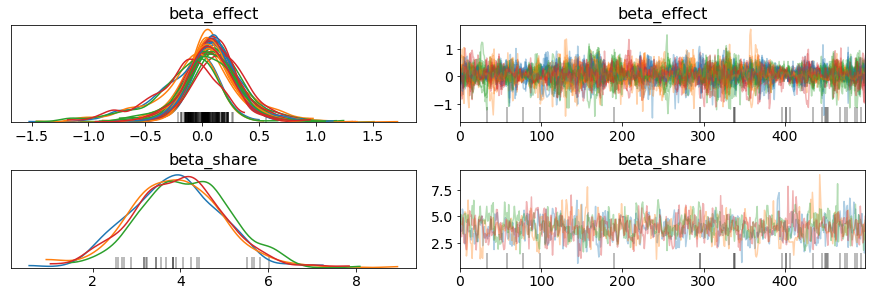

<IPython.core.display.Javascript object>

In [616]:
pm.traceplot(trace_negbin, var_names = ['beta_effect', 'beta_share'])

In [617]:
pm.summary(trace_negbin, var_names=['beta_effect', 'beta_share'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_effect[0],0.092,0.208,-0.284,0.513,0.006,0.005,1325.0,874.0,1267.0,1105.0,1.00
beta_effect[1],0.051,0.251,-0.455,0.527,0.008,0.006,905.0,796.0,942.0,876.0,1.00
beta_effect[2],0.166,0.246,-0.239,0.688,0.009,0.007,801.0,652.0,839.0,771.0,1.00
beta_effect[3],0.118,0.231,-0.303,0.571,0.008,0.006,841.0,635.0,903.0,998.0,1.01
beta_effect[4],0.104,0.247,-0.320,0.611,0.008,0.006,994.0,880.0,1041.0,1126.0,1.00
beta_effect[5],-0.178,0.309,-0.808,0.315,0.013,0.009,546.0,546.0,575.0,1285.0,1.01
beta_effect[6],0.081,0.217,-0.291,0.551,0.006,0.005,1488.0,898.0,1475.0,1486.0,1.01
beta_effect[7],0.062,0.253,-0.473,0.531,0.007,0.005,1201.0,1124.0,1244.0,892.0,1.00
beta_share,3.947,1.037,1.848,5.724,0.036,0.026,843.0,805.0,844.0,1188.0,1.01


<IPython.core.display.Javascript object>

# Binomial model

In [597]:
with pm.Model() as m_bin:
    
    policy = pm.Data('policy', policy_matrix)
    #alpha = pm.HalfNormal('alpha', 10)
    
    mu = pm.Normal('hyper_mu_re', 0, 2)
    sd = pm.HalfNormal('hyper_sd_re', 2)
    beta_effect = pm.Normal('beta_effect', mu, sd, shape = policy_matrix.shape[1]) 
    
    mu_fe = pm.Normal('hyper_mu_fe', 0, 1)
    sd_fe = pm.HalfNormal('hyper_sd_fe', 1)
    
    beta0_base = pm.Normal('beta0_base', 0, 1, shape = (deaths.shape[0]))
    beta0_effect = pm.Deterministic('beta0_effect', beta0_base * sd_fe + mu_fe)
    
    beta_share = pm.Normal('beta_share', 0, 100)
    #beta_share = pm.Deterministic('beta0_effect', beta0_base * sd_fe + mu_fe)  
    #beta0_effect = pm.Normal('beta0_effect', 0, 10, shape = (deaths.shape[0]))
    
    p_latent = beta0_effect + beta_share * share_black + tt.dot(policy, beta_effect) #+ beta_effect * policy
    #p = tt.exp(p_latent)
    p = pm.Deterministic('p', pm.math.sigmoid(p_latent))
    
    #obs = pm.NegativeBinomial('obs', mu = p, alpha = alpha, observed = black_deaths)
    obs = pm.Binomial('obs', n = black_pop, p = p, observed = black_deaths)

<IPython.core.display.Javascript object>

In [606]:
trace_bin = pm.sample(model=m_bin, tune=5000, target_accept = 0.995)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_share, beta0_base, hyper_sd_fe, hyper_mu_fe, beta_effect, hyper_sd_re, hyper_mu_re]
INFO:pymc3:NUTS: [beta_share, beta0_base, hyper_sd_fe, hyper_mu_fe, beta_effect, hyper_sd_re, hyper_mu_re]
Sampling 4 chains, 2 divergences: 100%|██████████| 22000/22000 [04:57<00:00, 74.06draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x174d9b3d0>,
      dtype=object)

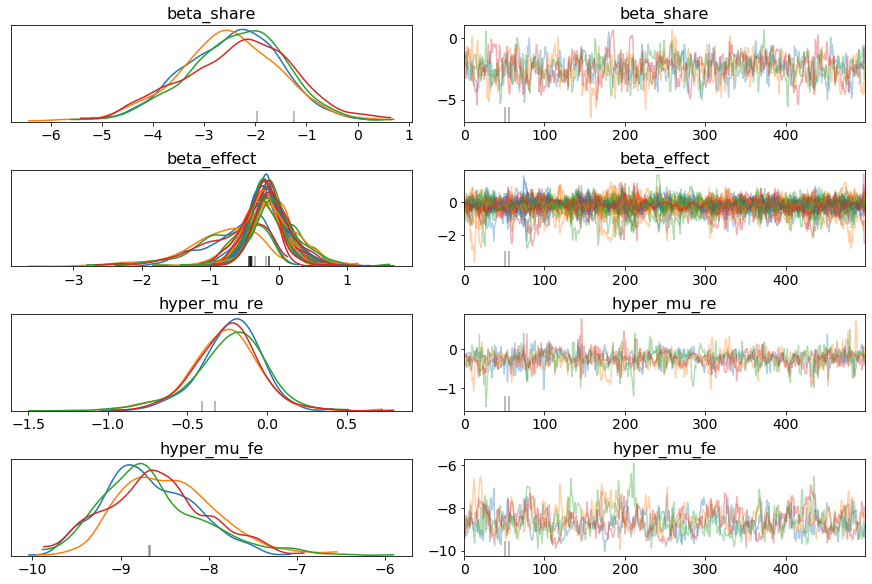

<IPython.core.display.Javascript object>

In [618]:
pm.traceplot(trace_bin, var_names = ['beta_share', 'beta_effect', 'hyper_mu_re', 'hyper_mu_fe'])

In [609]:
pm.summary(trace_bin, var_names = ['beta_effect', 'beta_share'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta_effect[0],-0.182,0.277,-0.682,0.367,0.012,0.009,523.0,523.0,541.0,682.0,1.01
beta_effect[1],-0.751,0.531,-1.721,0.029,0.035,0.024,236.0,236.0,233.0,370.0,1.02
beta_effect[2],-0.064,0.298,-0.572,0.557,0.013,0.009,558.0,558.0,560.0,1013.0,1.00
beta_effect[3],-0.189,0.261,-0.668,0.331,0.015,0.011,300.0,300.0,310.0,457.0,1.01
beta_effect[4],-0.146,0.320,-0.689,0.536,0.013,0.010,565.0,565.0,577.0,740.0,1.00
beta_effect[5],-0.314,0.302,-0.861,0.249,0.013,0.010,536.0,480.0,567.0,768.0,1.00
beta_effect[6],-0.219,0.275,-0.755,0.294,0.012,0.008,545.0,545.0,543.0,709.0,1.01
beta_effect[7],-0.046,0.335,-0.586,0.631,0.015,0.011,489.0,489.0,540.0,653.0,1.00
beta_share,-2.437,1.004,-4.400,-0.665,0.048,0.034,436.0,436.0,437.0,827.0,1.00


<IPython.core.display.Javascript object>

In [549]:
with pm.Model() as m_linear:
    
    mu = pm.Normal('hyper_mu_re', 0, 10)
    sd = pm.HalfNormal('hyper_sd_re', 10)
    beta_effect = pm.Normal('beta_effect', mu, sd, shape = (deaths.shape[0])) 
 
    #mu_2 = pm.Normal('hyper_mu_re_2', 0, 1)
    #sd_2 = pm.HalfNormal('hyper_sd_re_2', 1)
    #beta_effect_2_base = pm.Normal('beta_effect_2_base', 0, 1, shape = (deaths.shape[0])) 
    #beta_effect_2 = pm.Deterministic('beta_effect_2', beta_effect_2_base * sd_2 + mu_2)
    #beta_effect_2 = pm.Normal('beta_effect_2', 0, sd_2, shape = (deaths.shape[0])) 
    
    policy = pm.Data('policy', n_policies)
    mu_fe = pm.Normal('hyper_mu_fe', 0, 1)
    sd_fe = pm.HalfNormal('hyper_sd_fe', 1)
    beta0_base = pm.Normal('beta0_base', 0, 1, shape = (deaths.shape[0]))
    beta0_effect = pm.Deterministic('beta0_effect', beta0_base * sd_fe + mu_fe)
    #beta0_effect = pm.Normal('beta0_effect', mu_fe, sd_fe, shape = (deaths.shape[0]))
    
    p_latent = beta0_effect  + beta_effect * tt.log(policy) #+ beta_effect * policy
    #p = tt.exp(p_latent)
    p = pm.Deterministic('p', pm.math.sigmoid(p_latent))
    
    #obs = pm.NegativeBinomial('obs', mu = p, alpha = alpha, observed = deaths)
    obs = pm.Binomial('obs', n = pop, p = p, observed = deaths)

<IPython.core.display.Javascript object>

In [550]:
trace_linear = pm.sample(model=m_linear, tune=5000, target_accept = 0.9)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0_base, hyper_sd_fe, hyper_mu_fe, beta_effect, hyper_sd_re, hyper_mu_re]
INFO:pymc3:NUTS: [beta0_base, hyper_sd_fe, hyper_mu_fe, beta_effect, hyper_sd_re, hyper_mu_re]
Sampling 4 chains, 0 divergences:   0%|          | 0/22000 [00:00<?, ?draws/s]/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
INFO (theano.gof.compilelock): Waiting for existing lock by process '1257' (I am process '1256')
INFO (theano.gof.compilelock): Waiting for existing lock by process '1257' (I am process '1259')
INFO:theano.gof.compilelock:Waiting for existing lock by process '1257' (I am process '1256')
INFO (theano.gof.compilelock): To manually re

ParallelSamplingError: Bad initial energy

<IPython.core.display.Javascript object>

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.


In [537]:
pm.summary(trace_linear, var_names = 'beta0_effect')

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0_effect[0],-9.522,0.502,-10.465,-8.616,0.022,0.016,541.0,515.0,601.0,727.0,1.02
beta0_effect[1],-10.139,0.256,-10.639,-9.670,0.005,0.004,2535.0,2499.0,2687.0,1156.0,1.00
beta0_effect[2],-10.256,0.298,-10.795,-9.682,0.006,0.004,2834.0,2757.0,2982.0,1212.0,1.00
beta0_effect[3],-11.228,0.646,-12.401,-9.977,0.029,0.021,486.0,486.0,515.0,975.0,1.01
beta0_effect[4],-9.784,0.342,-10.422,-9.171,0.017,0.013,385.0,373.0,421.0,585.0,1.02
...,...,...,...,...,...,...,...,...,...,...,...
beta0_effect[85],-9.388,0.154,-9.671,-9.106,0.003,0.002,2331.0,2324.0,2351.0,1393.0,1.00
beta0_effect[86],-9.335,0.162,-9.647,-9.052,0.003,0.002,2420.0,2418.0,2437.0,1316.0,1.00
beta0_effect[87],-11.037,0.424,-11.837,-10.262,0.010,0.007,1746.0,1746.0,1699.0,1112.0,1.01
beta0_effect[88],-10.136,0.261,-10.644,-9.667,0.005,0.003,3092.0,3083.0,3077.0,1007.0,1.00


<IPython.core.display.Javascript object>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1648ae9d0>,
      dtype=object)

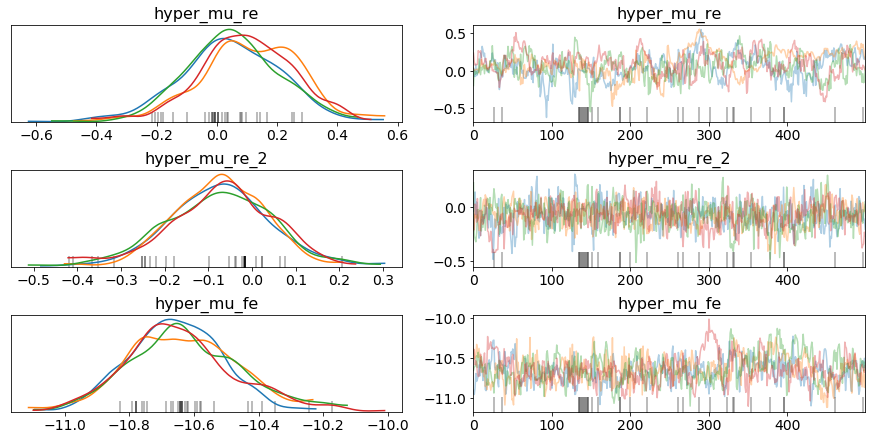

<IPython.core.display.Javascript object>

In [539]:
pm.traceplot(trace_linear, var_names=['hyper_mu_re', 'hyper_mu_re_2', 'hyper_mu_fe'])

In [521]:
posterior = pm.sample_posterior_predictive(trace_linear, model=m_linear)

100%|██████████| 2000/2000 [00:02<00:00, 854.34it/s]


<IPython.core.display.Javascript object>

In [522]:
pp_samples = posterior['obs']

<IPython.core.display.Javascript object>

In [530]:
all_8 = np.full_like(n_policies, 8)
all_8 = (all_8 - cities['policy_index'].values.mean()) / cities['policy_index'].values.std()

with m_linear:
    pm.set_data({'policy': all_8})
    new_posterior = pm.sample_posterior_predictive(trace=trace_linear)

100%|██████████| 2000/2000 [00:01<00:00, 1218.24it/s]


<IPython.core.display.Javascript object>

In [544]:
posterior['obs'].mean(axis =0)

array([ 50.1285,  13.546 ,  10.7125,   4.492 ,  23.3835,   3.6565,
         3.536 ,  31.508 ,  32.4415,  16.004 ,   2.502 ,   2.11  ,
         3.519 ,  23.719 ,  78.801 ,   5.127 ,  14.5105,   5.398 ,
        11.5755,   8.094 ,   4.5415,  42.078 ,  20.7905,   1.9265,
         8.706 ,  31.782 ,   5.775 ,  28.3225,   6.731 ,   2.0015,
         1.8505,   2.8005,  11.741 ,   2.8935,  28.367 ,   1.9495,
         6.5535,   6.907 ,  10.802 ,  13.2525,   2.543 ,   9.766 ,
         2.7555, 115.179 ,   3.1035,   4.251 ,   3.5045,   2.3025,
         1.936 ,  17.606 ,   8.154 ,   2.5595,  13.7605,  31.6495,
         2.87  ,   1.9075,   8.6495,  14.7705,  46.4945,  16.4925,
         1.954 ,  34.636 ,   3.1055,   7.037 ,   2.6695,   2.569 ,
         7.234 ,   1.531 ,  15.4445,   4.0735,  56.616 ,  13.291 ,
        31.9695,  19.975 ,  23.727 ,  15.651 ,  10.479 ,  25.5735,
        16.7395,  45.435 ,  13.6305,  13.581 ,   1.6495,  15.4375,
         7.9765,  43.9245,  34.9865,   7.51  ,  15.5235,   2.6

<IPython.core.display.Javascript object>

In [547]:
np.percentile(new_posterior['obs'], [2.5, 97.5], axis=0)

array([[1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        3.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 9.000000e+00, 0.00

<IPython.core.display.Javascript object>

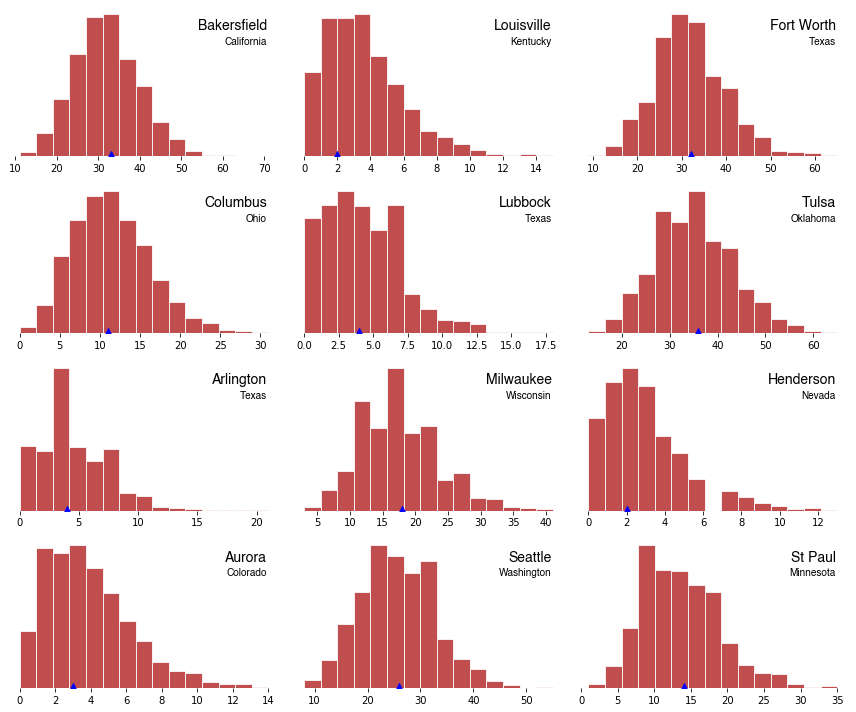

<IPython.core.display.Javascript object>

In [523]:
random_idx = np.random.choice(np.arange(pp_samples.shape[1]), replace = False, size = 12)
f, axes = plt.subplots(4, 3, figsize = (12, 10))
for ax, idx in zip(axes.ravel(), random_idx):
    ax.hist(posterior['obs'][:, idx], density = True, ec = 'w', bins = 15, color='firebrick', alpha = 0.8)
    ax.plot(deaths[idx], 0.0, "^", c = 'blue', ms = 10)
    ax.text(0.95, 0.85, city[idx], fontname='Helvetica', size= 14, transform=ax.transAxes, horizontalalignment='right')
    ax.text(0.95, 0.75, state[idx], fontname='Helvetica', size= 10, transform=ax.transAxes, horizontalalignment='right')
    #ax.set_yticklabels([])
    ax.set_yticks([])
    sns.despine(left = True, bottom=True)
    
plt.tight_layout()

In [524]:
change = sp.special.expit(trace_linear['beta_effect']*8 + trace_linear['beta0_effect']) / sp.special.expit(trace_linear['beta0_effect'])
change_from_now = sp.special.expit(trace_linear['beta_effect']*8 + trace_linear['beta0_effect']) / (sp.special.expit(trace_linear['beta_effect']* all_policies + trace_linear['beta0_effect'])  )

<IPython.core.display.Javascript object>

In [525]:
change_df = pd.DataFrame(change_from_now, columns=city)
mean_change = change_df.mean()
order_ = mean_change.sort_values().index

<IPython.core.display.Javascript object>

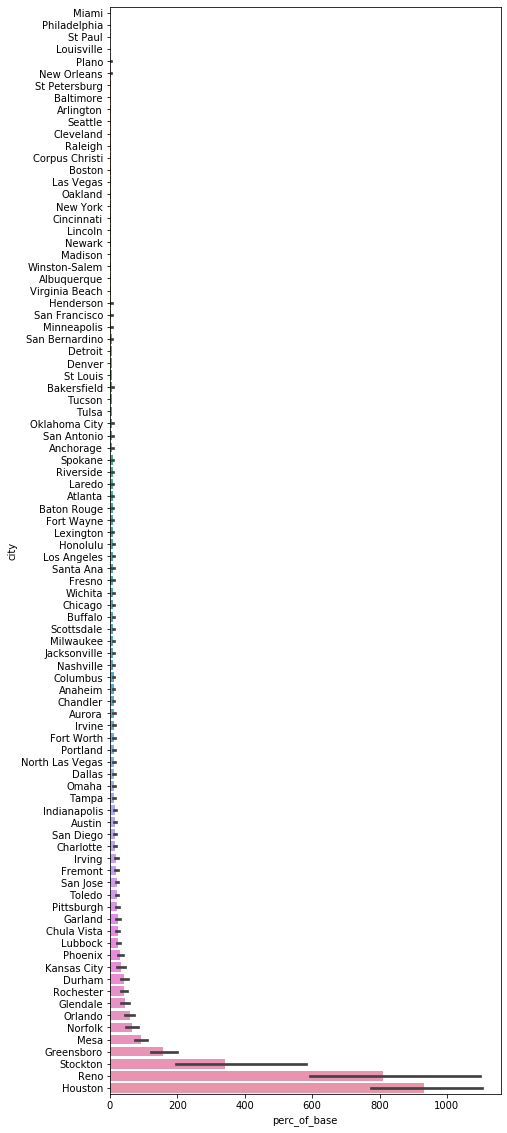

<IPython.core.display.Javascript object>

In [526]:
change_df = change_df.reset_index().melt(id_vars = ['index'], var_name = 'city', value_name = 'perc_of_base')

f, ax = plt.subplots(figsize = (7, 20))
sns.barplot(x = 'perc_of_base', y = 'city', data = change_df, order = order_, ax = ax)

In [457]:
beta_effect_posterior = pm.summary(trace_linear, var_names = 'beta_effect')
beta_effect_posterior.index = cities['city']
beta_effect_posterior = beta_effect_posterior.reset_index()
beta_effect_posterior

,city,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,Albuquerque,-0.108,0.160,-0.392,0.205,0.014,0.010,129.0,129.0,124.0,348.0,1.02
1,Anaheim,-0.194,0.178,-0.517,0.156,0.011,0.008,247.0,247.0,231.0,790.0,1.01
2,Anchorage,-0.203,0.164,-0.513,0.100,0.011,0.008,222.0,222.0,214.0,529.0,1.01
3,Arlington,-0.246,0.148,-0.540,0.011,0.010,0.007,239.0,239.0,232.0,804.0,1.01
4,Atlanta,-0.196,0.182,-0.518,0.158,0.011,0.008,285.0,284.0,263.0,876.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...
85,Tucson,-0.154,0.179,-0.485,0.178,0.012,0.009,214.0,214.0,208.0,647.0,1.01
86,Tulsa,-0.155,0.171,-0.430,0.209,0.013,0.009,188.0,188.0,181.0,882.0,1.01
87,Virginia Beach,-0.234,0.155,-0.518,0.064,0.010,0.007,227.0,226.0,225.0,615.0,1.02
88,Wichita,-0.201,0.167,-0.508,0.130,0.011,0.007,252.0,252.0,244.0,823.0,1.01


<IPython.core.display.Javascript object>

In [455]:
beta_0_posterior = pm.summary(trace_linear, var_names = 'beta0_effect')
beta_0_posterior.index = cities['city']
beta_0_posterior = beta_0_posterior.reset_index()
beta_0_posterior

,city,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,Albuquerque,-8.766,0.805,-10.373,-7.356,0.069,0.049,134.0,134.0,130.0,408.0,1.02
1,Anaheim,-9.572,0.573,-10.660,-8.470,0.036,0.025,259.0,259.0,252.0,865.0,1.01
2,Anchorage,-9.644,0.551,-10.657,-8.572,0.034,0.024,269.0,269.0,269.0,805.0,1.01
3,Arlington,-10.259,0.758,-11.656,-8.819,0.044,0.031,293.0,293.0,294.0,772.0,1.01
4,Atlanta,-9.425,0.417,-10.246,-8.703,0.021,0.015,383.0,383.0,367.0,896.0,1.01
...,...,...,...,...,...,...,...,...,...,...,...,...
85,Tucson,-8.928,0.558,-10.042,-7.971,0.037,0.026,229.0,229.0,227.0,645.0,1.01
86,Tulsa,-8.879,0.531,-9.922,-7.948,0.036,0.026,215.0,215.0,208.0,950.0,1.01
87,Virginia Beach,-10.161,0.668,-11.433,-8.945,0.041,0.029,265.0,265.0,266.0,883.0,1.02
88,Wichita,-9.546,0.548,-10.652,-8.551,0.031,0.022,322.0,322.0,317.0,819.0,1.01


<IPython.core.display.Javascript object>

In [456]:
beta_0_posterior[beta_0_posterior['city'] == 'St Louis']

,city,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
79,St Louis,-8.451,0.715,-9.848,-7.168,0.062,0.044,135.0,135.0,131.0,473.0,1.02


<IPython.core.display.Javascript object>

In [458]:
beta_effect_posterior[beta_effect_posterior['city'] == 'St Louis']

,city,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
79,St Louis,-0.103,0.177,-0.425,0.219,0.015,0.011,132.0,132.0,128.0,422.0,1.02


<IPython.core.display.Javascript object>

In [459]:
possible_rate = beta_0_posterior['mean'] + beta_effect_posterior['mean'] * 9
base_rate = beta_0_posterior['mean']

sp.special.expit(-.103 * 8 + -8.4) / sp.special.expit(-8.4)


0.43872881230366406

<IPython.core.display.Javascript object>

In [ ]:
sp.special(8 * -0.33)

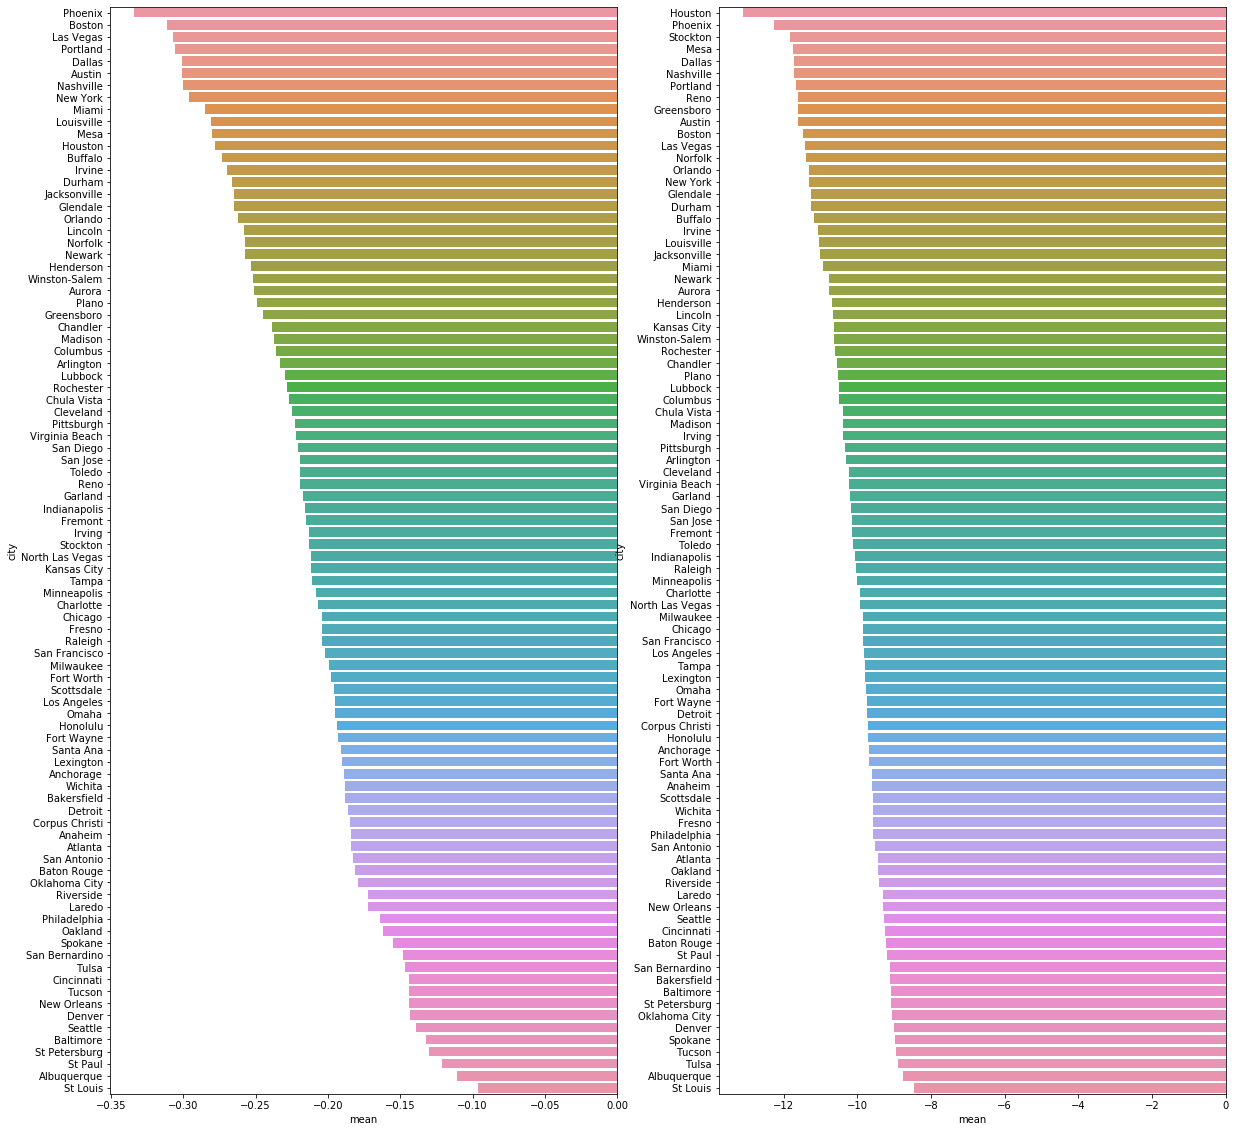

<IPython.core.display.Javascript object>

In [316]:
f, axes = plt.subplots(1, 2, figsize = (20, 20))
sns.barplot(x = 'mean', y = 'city', data = beta_effect_posterior.sort_values('mean'), ax = axes[0])
sns.barplot(x = 'mean', y = 'city', data = beta_0_posterior.sort_values('mean'), ax = axes[1])


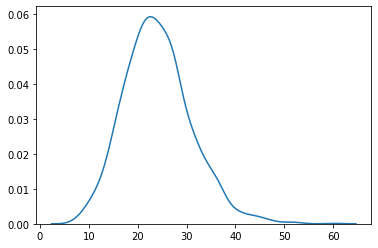

<IPython.core.display.Javascript object>

In [258]:
sns.kdeplot(posterior['obs'][:, 4])

In [255]:
deaths

array([ 51,  14,  11,   4,  24,   3,   2,  33,  33,  17,   1,   1,   3,
        24,  79,   5,  15,   5,  11,   8,   3,  43,  21,   1,   9,  32,
         6,  29,   7,   1,   1,   2,  12,   1,  29,   1,   7,   6,  11,
        14,   1,  10,   2, 115,   2,   4,   3,   1,   1,  18,   8,   1,
        14,  30,   2,   1,   9,  15,  48,  17,   1,  35,   1,   7,   2,
         1,   7,   1,  16,   4,  57,  14,  32,  20,  24,  16,  11,  26,
        18,  47,  14,  14,   1,  16,   8,  45,  36,   7,  16,   2])

<IPython.core.display.Javascript object>

In [226]:
with pm.Model() as m:
    
    mu = pm.Normal('hyper_mu', 0, 10)
    sd = pm.HalfNormal('hyper_sd', 10)
    
    policy_betas_base = pm.Normal('policy_betas', 0, 1, shape = (8, 1))
    policy_betas = policy_betas_base * sd + mu
    
    beta0 = pm.Normal('beta0', 0, 100)
    
    p_latent = beta0 + tt.dot(policy_matrix, policy_betas)
    p = pm.invlogit(p_latent)
    
    obs = pm.Binomial('obs', n = pop, p = p, observed = deaths)

<IPython.core.display.Javascript object>

In [227]:
trace = pm.sample(model=m, init='advi', tune=2000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi...
INFO:pymc3:Initializing NUTS using advi...
Average Loss = 73,187:  21%|██        | 41981/200000 [00:15<00:59, 2640.17it/s]    
Convergence achieved at 42000
INFO:pymc3.variational.inference:Convergence achieved at 42000
Interrupted at 41,999 [20%]: Average Loss = 6.538e+08
INFO:pymc3.variational.inference:Interrupted at 41,999 [20%]: Average Loss = 6.538e+08
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, policy_betas, hyper_sd, hyper_mu]
INFO:pymc3:NUTS: [beta0, policy_betas, hyper_sd, hyper_mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [08:57<00:00, 18.61draws/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the m

<IPython.core.display.Javascript object>

In [228]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
hyper_mu,0.000,0.002,-0.004,0.004,0.000,0.000,1596.0,821.0,1657.0,1191.0,1.00
"policy_betas[0,0]",-0.031,0.923,-1.875,1.578,0.022,0.020,1836.0,1057.0,1832.0,1478.0,1.00
"policy_betas[1,0]",-0.019,0.939,-1.699,1.835,0.023,0.020,1695.0,1150.0,1698.0,1504.0,1.00
"policy_betas[2,0]",-0.002,0.987,-1.919,1.782,0.020,0.024,2363.0,876.0,2411.0,1405.0,1.00
"policy_betas[3,0]",-0.023,0.955,-1.726,1.881,0.022,0.021,1840.0,1036.0,1839.0,1444.0,1.00
"policy_betas[4,0]",0.022,0.926,-1.793,1.682,0.017,0.022,2889.0,868.0,2914.0,1463.0,1.00
"policy_betas[5,0]",-0.028,0.950,-1.711,1.837,0.022,0.021,1937.0,1025.0,1947.0,1475.0,1.00
"policy_betas[6,0]",-0.005,0.960,-1.683,1.965,0.018,0.022,2729.0,939.0,2739.0,1405.0,1.00
"policy_betas[7,0]",-0.005,0.917,-1.848,1.613,0.016,0.023,3441.0,790.0,3473.0,1332.0,1.00
beta0,-10.605,0.006,-10.616,-10.593,0.000,0.000,1792.0,1792.0,1841.0,1055.0,1.00


<IPython.core.display.Javascript object>